# Credit Card Fraud Detection:
I found a dataset on credit card transactions that describes with labels on which transactions were fraudulent.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from scipy.stats import kde
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from collections import Counter

## Importing the Data
**Description given by the data providers**

- Data reference: https://www.kaggle.com/mlg-ulb/creditcardfraud

- The datasets contains transactions made by credit cards in September 2013 by european cardholders.
- This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions.
- The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. <br>

- It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. 
- Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
- Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
- The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. 
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
fraud_df = pd.read_csv('creditcard.csv')

### A note about the data
- **Time** is the number of seconds elapsed between this transaction and the first transaction in the dataset
- **Amount** is the amount spent on that transaction
- **Class** is the label on whether the transaction was fradulent or not
- **V1 - V28** are anonymized vectors to protect the users who made these transactions. They are unlabelled features that have undergone a dimensionality reduction with **Principal Component Analysis**

In [3]:
fraud_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

## Checking the Fradulent Cases
- Let's now make sure that the data does indeed have 492 fradulent transactions

In [4]:
## Add 1 to each counter if true or false
def class_identifier(data):
    fraudCounter, notFraudCounter = 0, 0
    for i in range(len(data)):
        if data['Class'][i] == 1:
            fraudCounter += 1
        else:
            notFraudCounter += 1
    return fraudCounter, notFraudCounter

In [5]:
numberOfFrauds, numberOfClean = class_identifier(fraud_df)

### Note that it is indeed the case that only 492 cases of Fraud Exist here

- This suggests an imbalance in the data. If a classification algorithm is to be built without overfitting, the data requires balancing. 
- There are many ways to balance data, but for now, some descriptive analysis on each feature should be done

In [6]:
print(f"Number of Fraud Transactions: {numberOfFrauds}")
print(f"Number of Clean Transactions: {numberOfClean}")

Number of Fraud Transactions: 492
Number of Clean Transactions: 284315


## Descriptive Analysis:

In [7]:
def normalize_data(fraud_df):
    fraud_df['normalizedAmount'] = StandardScaler().fit_transform(fraud_df['Amount'].values.reshape(-1,1))
    fraud_df = fraud_df.drop(['Amount'],axis=1)
    ## Time is irrelevant, as it seemed from the descriptive analysis, so dropping it, but only 
    ## When trying to classify, not when applying descriptive analysis
    ## fraud_df = fraud_df.drop(['Time'],axis=1)
    fraud_df = fraud_df.rename(columns = {
        'normalizedAmount' : 'Amount'
    })
    return fraud_df

In [8]:
## Plots a subplot
def plot_a_subplot(axes,index1, index2, title, xlabel, ylabel, plotType, data_to_be_plotted):
    ## First plot
    axes[index1,index2].set_title(title, size = 20)
    axes[index1,index2].set_xlabel(xlabel, size = 15)
    axes[index1,index2].set_ylabel(ylabel, size = 15)
    axes[index1,index2].grid(color='black', linestyle='--', linewidth=0.5)    
    if plotType == 'hist':
        axes[index1,index2].hist(data_to_be_plotted[data_to_be_plotted['Class']==0][data_to_be_plotted.columns[0]], bins = 60, color = '#1f77b4')
        axes[index1,index2].hist(data_to_be_plotted[data_to_be_plotted['Class']==1][data_to_be_plotted.columns[0]], bins = 60, color = 'red')
    elif plotType == 'scatter':
        is_fraud = fraud_df_normalized['Class'] == 1
        not_fraud = fraud_df_normalized['Class'] == 0
        ## plotting the points in a certain order
        axes[index1,index2].scatter(data_to_be_plotted[0][fraud_df_normalized['Class'] == 0]['Time'], data_to_be_plotted[1][fraud_df_normalized['Class'] == 0]['Amount'])
        axes[index1,index2].scatter(data_to_be_plotted[0][fraud_df_normalized['Class'] == 1]['Time'], data_to_be_plotted[1][fraud_df_normalized['Class'] == 1]['Amount'])        

## Plotting details
- Plotting the Number of transactions over time could give a good idea when credit card fraud could be taking place. 
    - For instance, is it during times where a lot of transactions are being made? 
    - Is it more common that multiple fradulent transactions are made at the same time, or are they usually spread apart? 
- A Scatter plot of the transaction amount over time may help with outlier detection.
    - Could help build a relationship between fraudulent transactions and transaction amount.
- Finally plotting the rest of the PCA features helps view the different distributions.
    - This helps with deciding how to approach a possible classifcation, and what features could help with a multilabel classifcation

In [9]:
print(fraud_df.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'Amount'],
      dtype='object')


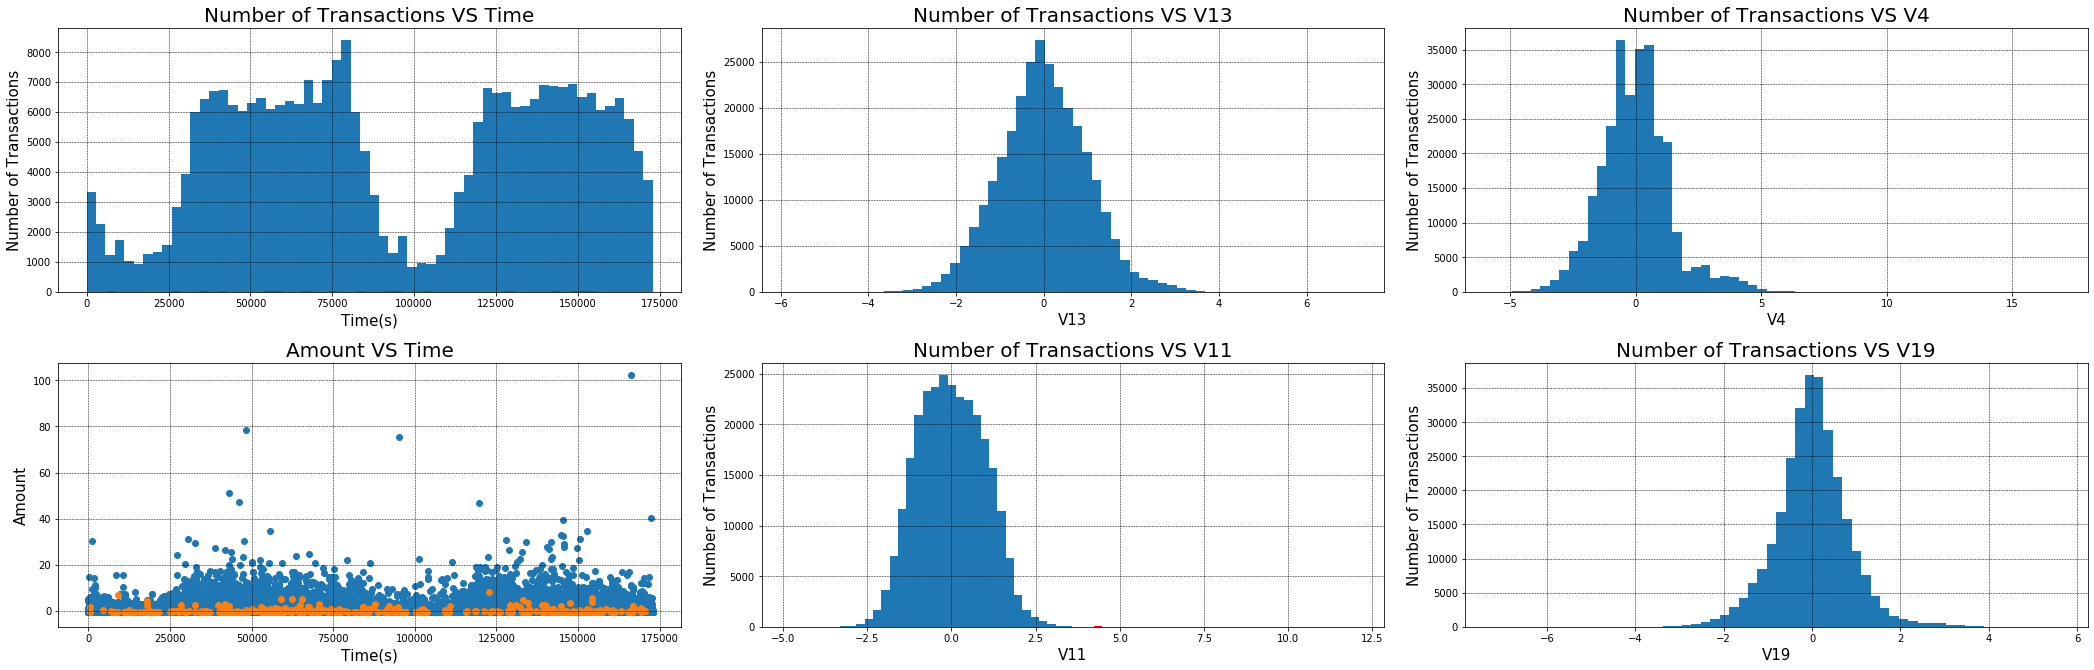

In [10]:
fig, axes = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=5.0)

fraud_df_normalized = normalize_data(fraud_df)
print(fraud_df_normalized.columns)

plot_a_subplot(axes, 0, 0, 'Number of Transactions VS Time', 'Time(s)', 'Number of Transactions', 'hist', fraud_df_normalized[['Time', 'Class']])
plot_a_subplot(axes, 1, 0, 'Amount VS Time', 'Time(s)', 'Amount', 'scatter', [fraud_df_normalized[['Time', 'Class']], fraud_df_normalized[['Amount', 'Class']], fraud_df_normalized['Class']])
plot_a_subplot(axes, 0, 1, 'Number of Transactions VS V13', 'V13', 'Number of Transactions', 'hist', fraud_df_normalized[['V13', 'Class']])
plot_a_subplot(axes, 0, 2, 'Number of Transactions VS V4', 'V4', 'Number of Transactions', 'hist', fraud_df_normalized[['V4', 'Class']])
plot_a_subplot(axes, 1, 1, 'Number of Transactions VS V11', 'V11', 'Number of Transactions', 'hist', fraud_df_normalized[['V11', 'Class']])
plot_a_subplot(axes, 1, 2, 'Number of Transactions VS V19', 'V19', 'Number of Transactions', 'hist', fraud_df_normalized[['V19', 'Class']])

## Correlation Matrix:

- A correlation matrix helps with seeing what kind of features should be selected for classification. Usually, the very highly correlated features are removed. This avoids teaching confusing the Machine Learning Model with "correlation implies causation"
- In the figure below, there are no highly correlated features so this gives no reason to exclude features.

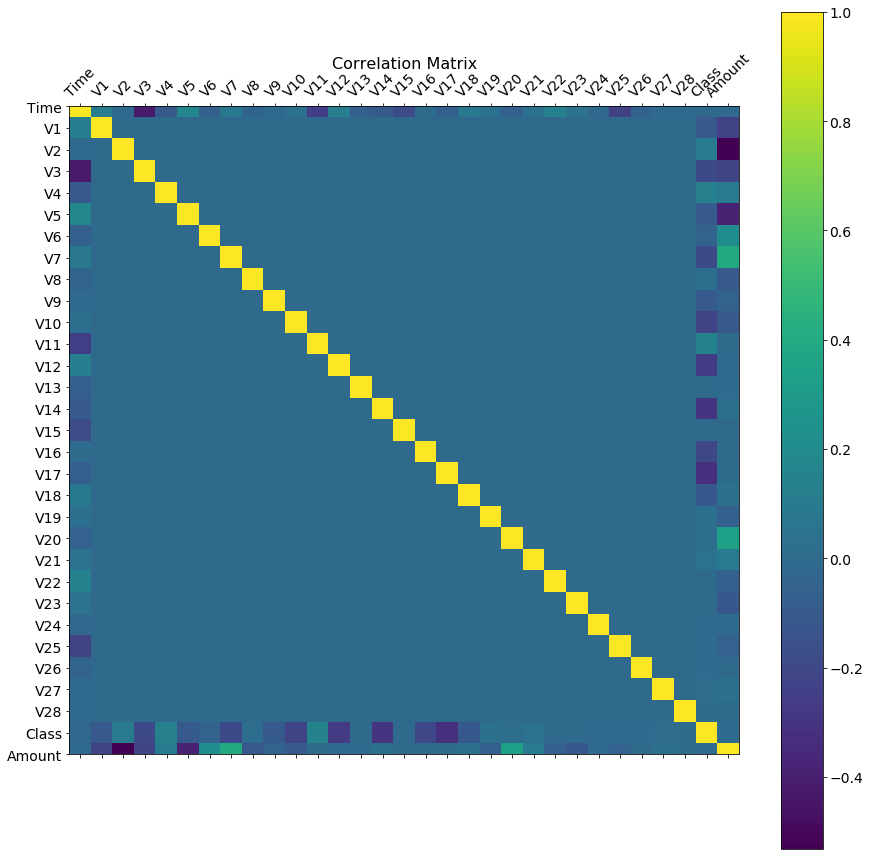

In [11]:
f = plt.figure(figsize = (15,15))
plt.matshow(fraud_df_normalized.corr('pearson'), f.number)
plt.xticks(range(fraud_df_normalized.shape[1]), fraud_df_normalized.columns, fontsize=14, rotation=45)
plt.yticks(range(fraud_df_normalized.shape[1]), fraud_df_normalized.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()

## Splitting features and labels

In [13]:
fraud_df_X = fraud_df_normalized.drop(['Class'], axis =1)
fraud_df_Y = fraud_df_normalized['Class']

## Objective: 
- The basic idea here is to try to classify Fradulent Transactions. It's a nice problem to consider because there a lot of obstacles of different kinds that show off different data science skills, especially with this kind of data (unbalanced)

## Balancing the Data:
- Now the data has to be balanced. SMOTE will be used, as this is a popular approach for similar data.
- Oversampling the data is better than reducing it, as in the case of fraudulent credit card transactions, it's better not to lose vital data.
    - There is too little data to begin with.
    - With undersampling, in the case of too little data and high variance, vital data could be lost
        - As seen before in the histograms plotted, the data shows a high degree of variance

## SMOTE: Synthetic Minority Oversampling Technique

In [14]:
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(fraud_df_X, fraud_df_Y)
X_res = X_res.drop('Time', axis = 1)

## Under-sampling with Cluster Centroids 

In [16]:
cluster_centroids = ClusterCentroids(random_state = 42)
X_underSam, y_underSam = cluster_centroids.fit_resample(fraud_df_X, fraud_df_Y)
print(sorted(Counter(y_underSam).items()))

NameError: name 'Counter' is not defined

## t-SNE: t-Distributed Stochastic Neighbor Embedding
An unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space. It was developed by Laurens van der Maatens and Geoffrey Hinton in 2008.

In [ ]:
X_res_embedded = TSNE(n_components = 2, random_state = 42).fit_transform(X_underSam)

In [ ]:
f, ax = plt.subplots(figsize=(24,16))

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

ax.scatter(X_res_embedded[:,0], X_res_embedded[:,1], c=(y_res == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax.scatter(X_res_embedded[:,0], X_res_embedded[:,1], c=(y_res == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

## K-means clustering:
- Let's now try to see if we can cluster the data in any way using k-means clustering. 
- First the ELBO method needs to be used in order to select the best number of clusters

In [20]:
## Elbo Method in action
def ELBO(iterations,df):
    dist = []
    K_range = range(1,iterations)
    for k in K_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(df)
        dist.append(kmeans.inertia_)
    return dist, K_range

In [68]:
distortions, K_range = ELBO(10, X_res)

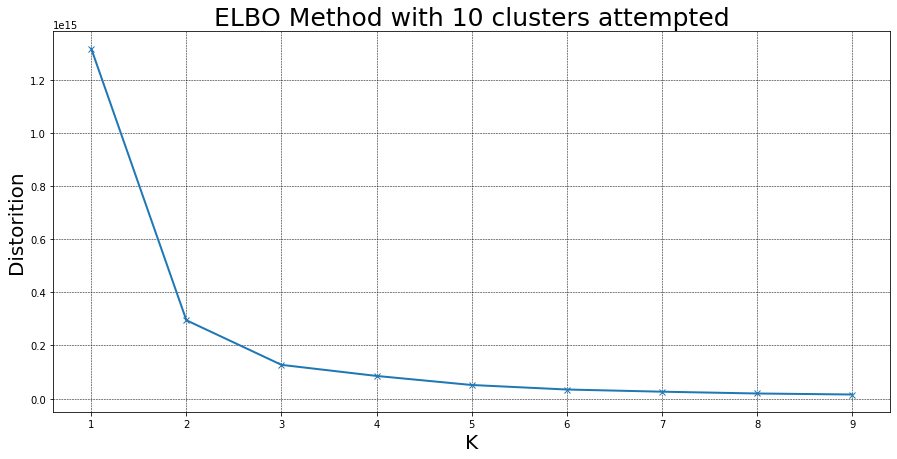

In [69]:
plt.figure(figsize = (15,7))
plt.title('ELBO Method with 10 clusters attempted', size= 25)
plt.plot(K_range, distortions, 'bx-', color = '#1f77b4', linewidth = 2)
plt.xlabel('K', size = 20)
plt.ylabel('Distorition', size = 20)
plt.grid(color='black', linestyle='--', linewidth=0.5)

It seems that 2 clusters are the best amount to select judging by the graph

In [21]:
kmeans = KMeans(n_clusters=2, tol = 0.00001, n_jobs = 20)
kmeans.fit(X_res)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=20, precompute_distances='auto',
       random_state=None, tol=1e-05, verbose=0)

In [22]:
X_res['k_means'] = kmeans.predict(X_res)

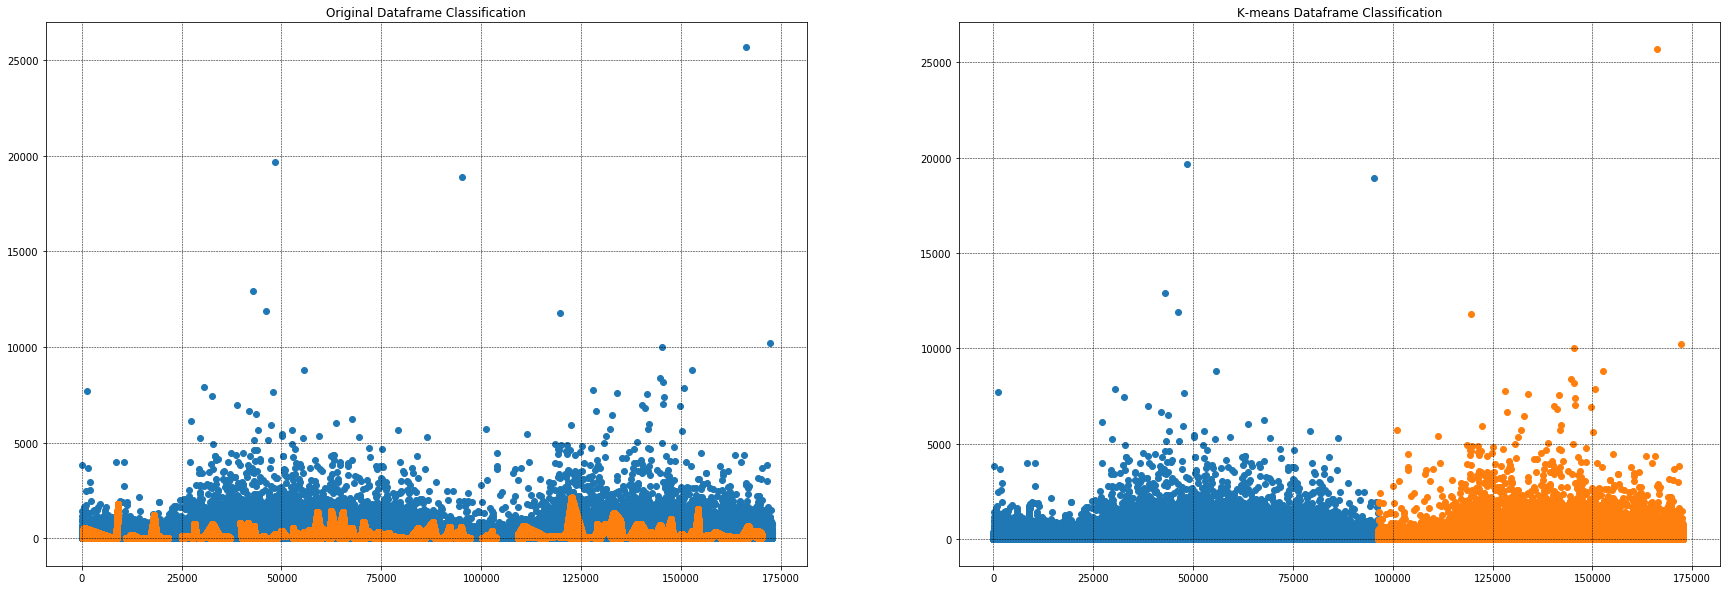

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(30,10))
axes[0].set_title('Original Dataframe Classification')
axes[0].scatter(np.array(X_res)[np.where(y_res == 0)][:,0], np.array(X_res)[np.where(y_res == 0)][:,-2])
axes[0].scatter(np.array(X_res)[np.where(y_res == 1)][:,0], np.array(X_res)[np.where(y_res == 1)][:,-2])
axes[0].grid(color='black', linestyle='--', linewidth=0.5)    


axes[1].set_title('K-means Dataframe Classification')
axes[1].scatter(X_res[X_res['k_means'] == 0]['Time'], X_res[X_res['k_means'] == 0]['Amount'])
axes[1].scatter(X_res[X_res['k_means'] == 1]['Time'], X_res[X_res['k_means'] == 1]['Amount'])
axes[1].grid(color='black', linestyle='--', linewidth=0.5)    